In [1]:
import numpy as np
from pandas import pandas as pd
import time
import copy
from pprint import pprint

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer, classification_report, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier

In [2]:
dt = pd.read_csv("dataset_fourth.csv", engine='python')
data = copy.copy(dt)
data.head()

,Unnamed: 0,icustay_id,mergeID,label,creatinine_tomorrow,creatinine_yesterday,creatinine_before_yesterday,arterial_pressure_systolic,arterial_pressure_systolic_delay,arterial_pressure_systolic_time,...,total_protein_urine_time,bilirubin,bilirubin_delay,bilirubin_time,c_reactive_protein,c_reactive_protein_delay,c_reactive_protein_time,ethnicity,diagnosis,gender
0,1,200001,200001 2181-11-26 05:36:00,0,3.5,NaN,NaN,NaN,NaN,NaN,...,NaN,0.2,0.0,2181-11-26 05:36:00,NaN,NaN,NaN,ASIAN - ASIAN INDIAN,ALTERED MENTAL STATUS,F
1,2,200001,200001 2181-11-27 05:54:00,1,2.9,2.7,NaN,NaN,NaN,NaN,...,NaN,0.2,87480.0,2181-11-26 05:36:00,NaN,NaN,NaN,ASIAN - ASIAN INDIAN,ALTERED MENTAL STATUS,F
2,3,200003,200003 2199-08-03 01:47:00,1,0.7,NaN,NaN,NaN,NaN,NaN,...,NaN,3.4,0.0,2199-08-03 01:47:00,NaN,NaN,NaN,WHITE,S/P RESECTION,M
3,4,200003,200003 2199-08-04 01:21:00,2,0.8,1.0,NaN,NaN,NaN,NaN,...,NaN,3.9,27840.0,2199-08-03 17:37:00,NaN,NaN,NaN,WHITE,S/P RESECTION,M
4,5,200003,200003 2199-08-05 02:25:00,2,0.7,0.7,1.0,NaN,NaN,NaN,...,NaN,4.7,0.0,2199-08-05 02:25:00,NaN,NaN,NaN,WHITE,S/P RESECTION,M


In [3]:
data = dt
# Remove outliers
feat_names = ['creatinine_yesterday', 'creatinine_before_yesterday',
              'urea', 'potassium','gender', 'ethnicity', 'diagnosis',# 'gender', 'ethnicity', '',
              'platelet_count', 'ph_blood',
              'creatinine', 'age', 'bilirubin']
feat_names = feat_names + ['urea_delay', 'potassium_delay','platelet_count_delay',
                           'ph_blood_delay', 'bilirubin_delay']
feat_lab = feat_names + ['label']
print('Initial data length: ', len(data))
data = data[feat_lab]

# Remove outliers
data = data[data['creatinine'] < 20]
data = data[data['creatinine_yesterday'] < 20]
data = data[data['creatinine_before_yesterday'] < 20]
data = data[data['potassium'] > 1.2]
data = data[data['ph_blood'] > 6]
data = data[data['age'] < 110]
data = data[data['bilirubin'] < 20]
data['gender'] = data['gender'].map({'F': 1, 'M': 0})

# Remove Nan
for name in feat_names:
    try:
        data = data[np.isfinite(data[name])]
    except:
        print(name)
        data = data[data[name].isnull() == False]
print('\nTotal entries: ', len(data))
print(data.isnull().sum())

Initial data length:  143048
ethnicity
diagnosis

Total entries:  47013
creatinine_yesterday           0
creatinine_before_yesterday    0
urea                           0
potassium                      0
gender                         0
ethnicity                      0
diagnosis                      0
platelet_count                 0
ph_blood                       0
creatinine                     0
age                            0
bilirubin                      0
urea_delay                     0
potassium_delay                0
platelet_count_delay           0
ph_blood_delay                 0
bilirubin_delay                0
label                          0
dtype: int64


In [4]:
data['ethnicity'].unique()



data['ethnicity'] = data['ethnicity'].map({'BLACK/AFRICAN AMERICAN': 'BLACK', 
                                           'WHITE': 'WHITE', 
                                           'UNKNOWN/NOT SPECIFIED': 'NaN',
                                           'HISPANIC/LATINO - DOMINICAN': 'OTHER', 
                                           'UNABLE TO OBTAIN': 'NaN',
                                           'PATIENT DECLINED TO ANSWER': 'NaN', 
                                           'ASIAN - CHINESE': 'ASIAN',
                                           'AMERICAN INDIAN/ALASKA NATIVE': 'OTHER', 
                                           'MULTI RACE ETHNICITY': 'OTHER',
                                           'WHITE - OTHER EUROPEAN': 'WHITE', 
                                           'OTHER': 'OTHER', 
                                           'PORTUGUESE': 'WHITE',
                                           'HISPANIC OR LATINO': 'OTHER', 
                                           'ASIAN': 'ASIAN', 
                                           'HISPANIC/LATINO - PUERTO RICAN': 'OTHER',
                                           'MIDDLE EASTERN': 'OTHER', 
                                           'ASIAN - KOREAN': 'ASIAN', 
                                           'BLACK/HAITIAN': 'BLACK',
                                           'ASIAN - OTHER': 'ASIAN', 
                                           'HISPANIC/LATINO - CUBAN': 'OTHER', 
                                           'ASIAN - FILIPINO': 'ASIAN',
                                           'BLACK/CAPE VERDEAN': 'BLACK', 
                                           'WHITE - BRAZILIAN': 'WHITE', 
                                           'ASIAN - ASIAN INDIAN': 'ASIAN',
                                           'WHITE - EASTERN EUROPEAN': 'WHITE', 
                                           'HISPANIC/LATINO - GUATEMALAN': 'OTHER',
                                           'ASIAN - VIETNAMESE': 'ASIAN', 
                                           'HISPANIC/LATINO - MEXICAN': 'OTHER',
                                           'WHITE - RUSSIAN': 'WHITE', 
                                           'BLACK/AFRICAN': 'BLACK', 
                                           'ASIAN - CAMBODIAN': 'ASIAN',
                                           'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE': 'OTHER'})
data['ethnicity'].unique()
data.tail()

,creatinine_yesterday,creatinine_before_yesterday,urea,potassium,gender,ethnicity,diagnosis,platelet_count,ph_blood,creatinine,age,bilirubin,urea_delay,potassium_delay,platelet_count_delay,ph_blood_delay,bilirubin_delay,label
143038,0.4,0.6,14.0,3.4,0,WHITE,STATUS POST MOTOR VEHICLE ACCIDENT WITH INJURIES,689.0,7.42,0.5,41.594026,0.3,0.0,44340.0,0.0,300.0,395880.0,2
143039,0.5,0.4,12.0,3.4,0,WHITE,STATUS POST MOTOR VEHICLE ACCIDENT WITH INJURIES,640.0,7.42,0.4,41.594026,0.3,0.0,135420.0,0.0,91380.0,486960.0,2
143040,0.4,0.5,15.0,3.4,0,WHITE,STATUS POST MOTOR VEHICLE ACCIDENT WITH INJURIES,484.0,7.42,0.5,41.594026,0.3,0.0,214860.0,0.0,170820.0,566400.0,2
143046,3.8,5.2,38.0,4.4,1,WHITE,GALLSTONE;FAILED ERCP,128.0,7.35,4.1,74.234336,1.4,0.0,34080.0,0.0,16740.0,163320.0,0
143047,4.1,3.8,49.0,4.4,1,WHITE,GALLSTONE;FAILED ERCP,142.0,7.34,4.7,74.234336,1.4,0.0,130740.0,0.0,22080.0,259980.0,1


In [5]:
len(data['diagnosis'].unique())
diag_to_stay = ['PNEUMONIA', 'CONGESTIVE HEART FAILURE', 'SUBARACHNOID HEMORRHAGE',
               'INTRACRANIAL HEMORRHAGE', 'ALTERED MENTAL STATUS', 'CORONARY ARTERY DISEASE',
               'ABDOMINAL PAIN', 'CHEST PAIN', 'HYPOTENSION', 'ACUTE RENAL FAILURE',
               'RESPIRATORY FAILURE', 'GASTROINTESTINAL BLEED', 'PANCREATITIS', 'SEPSIS']
'YS' in data['diagnosis'].iloc[1]
for i in range(len(data['diagnosis'])):
    value = data['diagnosis'].iat[i]
    if 'FEVER' in value:
        data['diagnosis'].iat[i] = 'SEPSIS'
    elif 'DYSPNEA' in value or 'SHORTNESS OF BREATH' in value:
        data['diagnosis'].iat[i] = 'RESPIRATORY FAILURE'
    elif value not in diag_to_stay:
        data['diagnosis'].iat[i] = 'OTHER'
data['diagnosis'].unique()

array(['ALTERED MENTAL STATUS', 'OTHER', 'RESPIRATORY FAILURE',
       'HYPOTENSION', 'CONGESTIVE HEART FAILURE', 'CHEST PAIN', 'SEPSIS',
       'INTRACRANIAL HEMORRHAGE', 'GASTROINTESTINAL BLEED',
       'ACUTE RENAL FAILURE', 'PNEUMONIA', 'ABDOMINAL PAIN',
       'SUBARACHNOID HEMORRHAGE', 'CORONARY ARTERY DISEASE', 'PANCREATITIS'], dtype=object)

In [6]:
print(feat_names)
data = pd.get_dummies(data)
data.head()

['creatinine_yesterday', 'creatinine_before_yesterday', 'urea', 'potassium', 'gender', 'ethnicity', 'diagnosis', 'platelet_count', 'ph_blood', 'creatinine', 'age', 'bilirubin', 'urea_delay', 'potassium_delay', 'platelet_count_delay', 'ph_blood_delay', 'bilirubin_delay']


,creatinine_yesterday,creatinine_before_yesterday,urea,potassium,gender,platelet_count,ph_blood,creatinine,age,bilirubin,...,diagnosis_CORONARY ARTERY DISEASE,diagnosis_GASTROINTESTINAL BLEED,diagnosis_HYPOTENSION,diagnosis_INTRACRANIAL HEMORRHAGE,diagnosis_OTHER,diagnosis_PANCREATITIS,diagnosis_PNEUMONIA,diagnosis_RESPIRATORY FAILURE,diagnosis_SEPSIS,diagnosis_SUBARACHNOID HEMORRHAGE
16,0.8,0.8,19.0,3.8,0,166.0,7.40,0.8,54.19308,14.8,...,0,0,0,0,0,0,0,0,0,0
19,0.7,0.6,10.0,2.7,0,123.0,7.50,0.5,67.14657,1.4,...,0,0,0,0,1,0,0,0,0,0
20,0.5,0.7,11.0,2.7,0,139.0,7.49,0.5,67.14657,1.4,...,0,0,0,0,1,0,0,0,0,0
21,0.5,0.5,13.0,2.7,0,171.0,7.49,0.5,67.14657,1.4,...,0,0,0,0,1,0,0,0,0,0
22,0.5,0.5,17.0,2.7,0,241.0,7.48,0.5,67.14657,1.4,...,0,0,0,0,1,0,0,0,0,0


## Model selection part

In [7]:
y = data['label']
feat_names = list(data)
feat_names.remove('label')
X = data[feat_names]
X.head()

,creatinine_yesterday,creatinine_before_yesterday,urea,potassium,gender,platelet_count,ph_blood,creatinine,age,bilirubin,...,diagnosis_CORONARY ARTERY DISEASE,diagnosis_GASTROINTESTINAL BLEED,diagnosis_HYPOTENSION,diagnosis_INTRACRANIAL HEMORRHAGE,diagnosis_OTHER,diagnosis_PANCREATITIS,diagnosis_PNEUMONIA,diagnosis_RESPIRATORY FAILURE,diagnosis_SEPSIS,diagnosis_SUBARACHNOID HEMORRHAGE
16,0.8,0.8,19.0,3.8,0,166.0,7.40,0.8,54.19308,14.8,...,0,0,0,0,0,0,0,0,0,0
19,0.7,0.6,10.0,2.7,0,123.0,7.50,0.5,67.14657,1.4,...,0,0,0,0,1,0,0,0,0,0
20,0.5,0.7,11.0,2.7,0,139.0,7.49,0.5,67.14657,1.4,...,0,0,0,0,1,0,0,0,0,0
21,0.5,0.5,13.0,2.7,0,171.0,7.49,0.5,67.14657,1.4,...,0,0,0,0,1,0,0,0,0,0
22,0.5,0.5,17.0,2.7,0,241.0,7.48,0.5,67.14657,1.4,...,0,0,0,0,1,0,0,0,0,0


In [8]:
print(len(list(X)))
print(y.value_counts()/len(y))

35
2    0.652266
1    0.191054
0    0.156680
Name: label, dtype: float64


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Split to three test sets
test_size = len(X_test) // 2
X_validation = X_test[0:test_size]
y_validation = y_test[0:test_size]

X_test = X_test[test_size:-1]
y_test = y_test[test_size:-1]

##### Train an adaboost classifier with random forests as base estimator on all features

In [10]:
def hyp_tuning(X_train, X_validation, y_train):
    # Initialize the classifier
    clf = AdaBoostClassifier(RandomForestClassifier(class_weight="balanced"))

    # Create cross-validation sets from the training data
    cv_sets = StratifiedShuffleSplit(n_splits=3, 
                                     test_size=0.1, 
                                     train_size=None, 
                                     random_state=42)

    # Create the parameters list you wish to tune
    parameters = {'n_estimators': [50, 100],
                  'learning_rate': [0.5, 1.0]}

    # Make an fbeta_score scoring object
    scorer = make_scorer(fbeta_score, beta = 0.5, average = 'weighted')

    # Perform grid search on the classifier using 'scorer' as the scoring method
    grid_obj = GridSearchCV(clf, 
                            param_grid = parameters, 
                            scoring = scorer, 
                            cv = cv_sets, 
                            n_jobs = 1) #-1)

    # Fit the grid search object to the training data and find the optimal parameters
    grid_fit = grid_obj.fit(X_train, y_train)

    # Get the estimator
    best_clf = grid_fit.best_estimator_

    # Make predictions using the unoptimized and model
    best_predictions = best_clf.predict(X_validation)
    return best_clf, best_predictions

# Report the before-and-afterscores
start = time.time()

best_clf, best_predictions = hyp_tuning(X_train, X_validation, y_train)

end = time.time()
print("\nTime elapsed: ", (end - start)/60, " min")
print("\nBest classifier: ", best_clf)
conf = confusion_matrix(y_validation, best_predictions)
print("Confusion matrix")
pprint(conf)

print("\nClassification report")
print(classification_report(y_validation, best_predictions))


Time elapsed:  38.92724130153656  min

Best classifier:  AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          learning_rate=1.0, n_estimators=100, random_state=None)
Confusion matrix
array([[ 165,  188,  392],
       [ 103,  381,  417],
       [  63,  154, 2838]])

Classification report
             precision    recall  f1-score   support

          0       0.50      0.22      0.31       745
          1       0.53      0.42      0.47       901
          2       0.78      0.93      0.85      3055

avg / total       0.69      0.72      0.69      4701



### Final test set

In [11]:
best_predictions = best_clf.predict(X_test)
conf = confusion_matrix(y_test, best_predictions)

print("Confusion matrix")
pprint(conf)

print("\nClassification report")
print(classification_report(y_test, best_predictions))

Confusion matrix
array([[ 154,  175,  431],
       [  99,  366,  443],
       [  56,  161, 2816]])

Classification report
             precision    recall  f1-score   support

          0       0.50      0.20      0.29       760
          1       0.52      0.40      0.45       908
          2       0.76      0.93      0.84      3033

avg / total       0.67      0.71      0.67      4701



### Principal component analysis

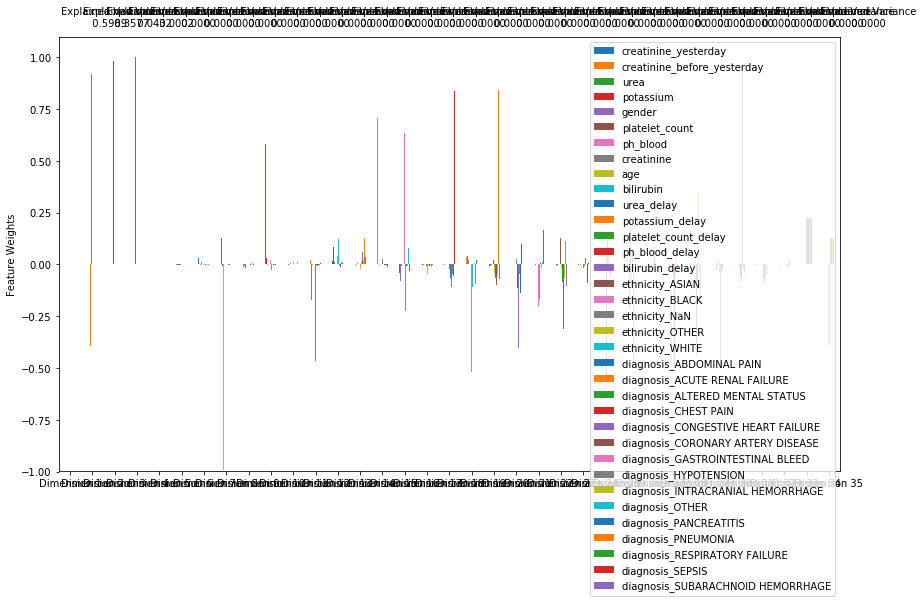

In [14]:
from sklearn.decomposition import PCA
import visuals as vs

pca = PCA(n_components = X.shape[1], random_state= 42).fit(X)

pca_results = vs.pca_results(X, pca)